In [2]:
from datetime import datetime

from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.visualization import hist

from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
#%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#rootdir = Path("/mnt/e/wfsdat")
rootdir = Path("./data")
# use find to make this csv list
with open(rootdir / "2024_q2.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [4]:
g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
binospec,16479,1,binospec,16479
f5,811,1,f5,811
mmirs,2239,1,mmirs,2239
newf9,190,1,newf9,190


In [5]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
#fixed_list = []
#for wfskey, group in g:
#    wfs = wfs_systems[wfskey]
#    group = g.get_group(wfskey)
#    #group.apply(seeing, axis=1, args=(wfs,))
#    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
#    fixed_list.append(group)
#fixed = pd.concat(fixed_list)
#fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
#fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
fixed = data[np.isfinite(data['seeing'])]
fixed = fixed[fixed['fwhm'] > 0.]
fixed = fixed[fixed['seeing'] > 0.]
fixed = fixed[fixed['seeing'] < 4.]
#fixed = fixed[fixed['time'] < "2020-12-31"]

In [6]:
fixed.sort_values(by='time')

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,focerr,cc_x_err,cc_y_err,xcen,ycen,seeing,raw_seeing,fwhm,wavefront_rms,residual_rms
0,2024-04-03T07:20:58.644000,binospec,wfs_ff_cal_img_2024.04.03T072058.644.fits,10.0,1.1416,247.349340,61.159482,2.6,2.07,2.9,...,-56.39,-21.215,-10.167,276.010573,258.486430,1.976714,2.140189,9.735375,1844.923665,1862.800870
1,2024-04-03T07:21:11.865000,binospec,wfs_ff_cal_img_2024.04.03T072111.865.fits,10.0,1.1422,247.433357,61.101052,2.6,2.08,2.9,...,-64.16,-15.764,-9.300,275.001867,260.489448,1.965357,2.128565,9.692457,1899.264316,1811.526832
2,2024-04-03T07:21:24.994000,binospec,wfs_ff_cal_img_2024.04.03T072124.994.fits,10.0,1.1427,247.489061,61.062150,2.6,2.06,3.0,...,-35.26,-15.157,-6.654,275.007453,260.489989,2.060389,2.232073,10.073450,1298.116156,1898.446604
3,2024-04-03T07:21:38.102000,binospec,wfs_ff_cal_img_2024.04.03T072138.102.fits,10.0,1.1431,247.544572,61.023537,2.6,1.98,3.0,...,5.43,-11.306,-2.041,276.994102,257.500445,1.909793,2.069364,9.473351,651.697180,1851.280928
4,2024-04-03T07:21:51.232000,binospec,wfs_ff_cal_img_2024.04.03T072151.232.fits,10.0,1.1435,247.599976,60.984891,2.6,2.04,2.9,...,24.81,-0.000,0.688,278.993324,256.495169,1.706056,1.848992,8.649639,813.655530,1616.747070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2024-06-30T03:26:42.868000,f5,f5wfs_20240629-202714.fits,30.0,1.5837,199.476738,39.156217,19.0,18.69,19.6,...,28.13,-5.547,-3.269,260.994696,247.009482,1.065185,1.403553,8.116136,1017.586880,2018.294440
8,2024-06-30T03:27:37.814000,f5,f5wfs_20240629-202810.fits,30.0,1.5922,199.675876,38.907061,19.0,18.69,19.6,...,3.31,-1.122,-1.745,255.001884,246.000182,0.870870,1.151204,6.966361,355.763036,2057.739393
9,2024-06-30T04:26:52.584000,f5,f5wfs_20240629-212725.fits,30.0,1.5252,203.557268,40.970699,20.0,18.69,19.8,...,26.72,3.085,2.391,245.004872,263.996619,0.946907,1.219841,7.281452,761.009816,1719.068475
10,2024-06-30T04:27:41.270000,f5,f5wfs_20240629-212814.fits,30.0,1.5272,203.796886,40.903601,20.0,18.69,19.7,...,5.20,-0.000,1.541,247.007034,264.995902,1.046659,1.349407,7.871425,476.597708,1699.249645


In [7]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

<Figure size 800x500 with 0 Axes>

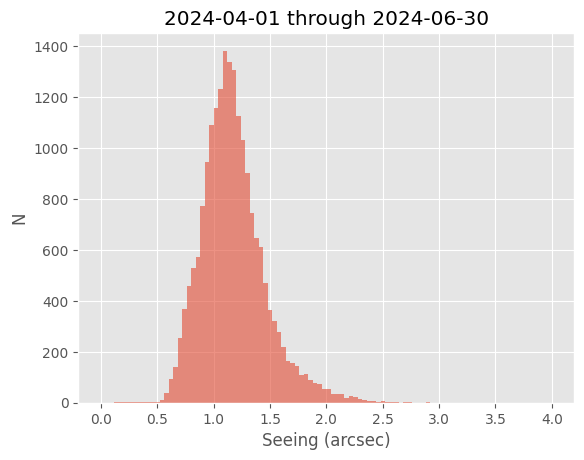

In [8]:
# make raw histogram of the zenith-corrected seeing column
fig = plt.figure(figsize=(8, 5))
fixed.hist(column='seeing', bins=100, range=(0.0, 4.0), alpha=0.6)
with plt.style.context('ggplot'):
    plt.title("2024-04-01 through 2024-06-30")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
plt.show()

In [9]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(fixed['seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(fixed['seeing'])
fit_median = exp_mu + loc

0.21126325623322204 -0.13672543142755794 1.2826269953810774


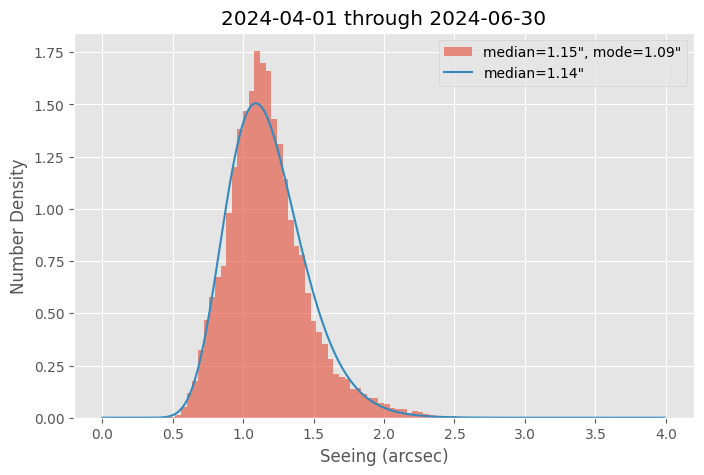

In [10]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(fixed['seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title("2024-04-01 through 2024-06-30")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig("2024_q2.png")
plt.show()

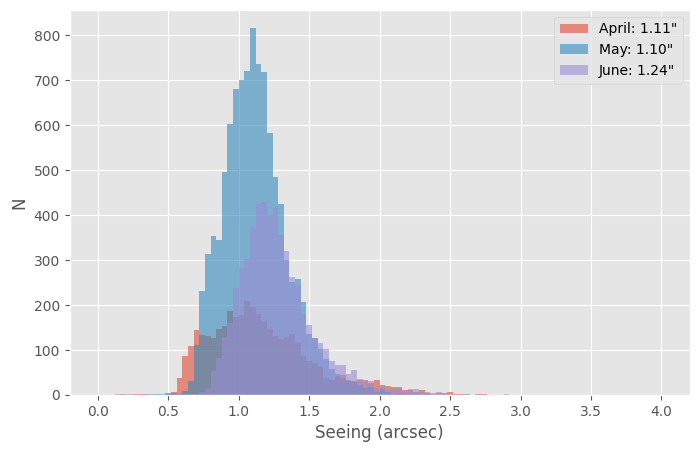

In [11]:
# panda time indexing makes it easy to group by month
fig = plt.figure(figsize=(8, 5))
months = {}
legends = []
months['April'] = fixed.loc['2024-04']
months['May'] = fixed.loc['2024-05']
months['June'] = fixed.loc['2024-06']

for m in months:
    plt.hist(months[m]['seeing'], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(months[m]['seeing']))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig("2024_q2_monthly.png")
plt.show()

In [12]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['seeing'])
med_2nd = np.median(second_half['seeing'])

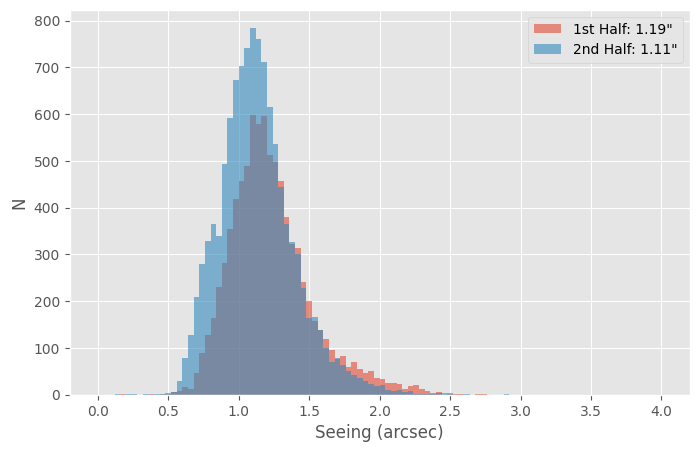

In [13]:
# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("2024_q2_1st2nd.png")
plt.show()

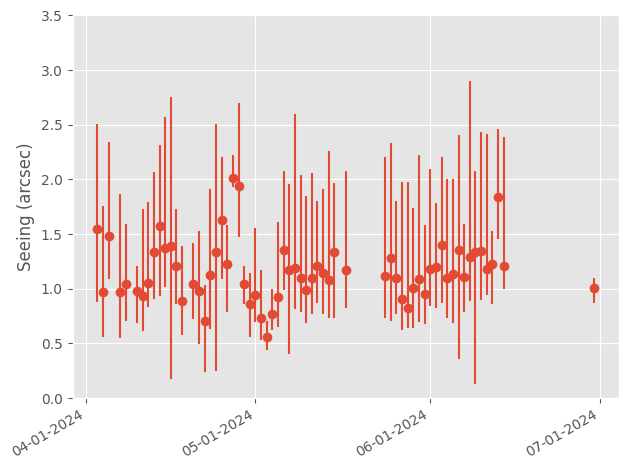

In [15]:
import matplotlib.dates as mdates

# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
#fixed = fixed["2018-06-30":"2018-10-01"]
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = fixed.seeing.resample('D').median()
daily['max'] = fixed.seeing.resample('D').max()
daily['min'] = fixed.seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
ax.set_ylim(0.0, 3.5)
fig.autofmt_xdate()
plt.tight_layout()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig("2024_q2_nightly.png")
plt.show()

In [16]:
date_list = list(daily.index.strftime('%Y-%m-%d'))
data = [np.array(fixed.loc[date]['seeing']) for date in date_list]
clean_data = {}
for d, arr in zip(date_list, data):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m-%d").date() for d in clean_data.keys()]

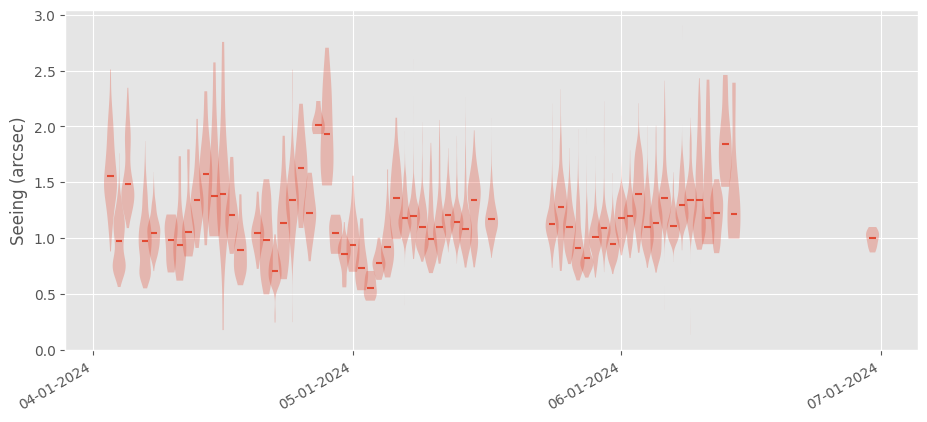

In [17]:
with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig("2024_q2_violin.png")
    plt.show()

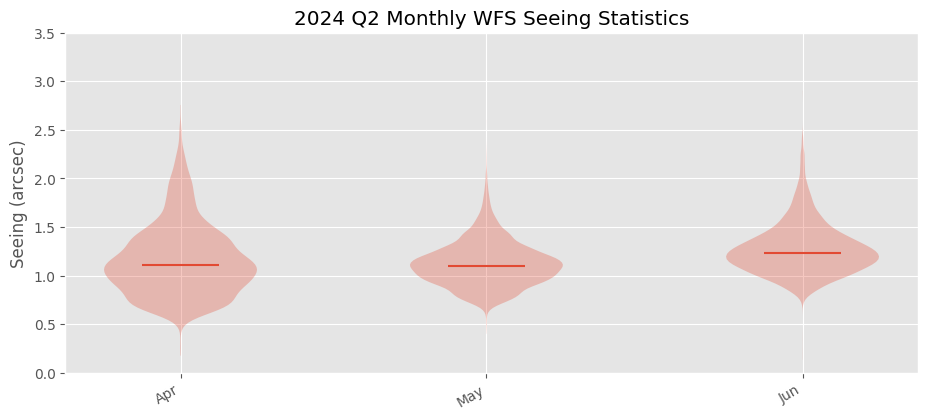

In [18]:
months = sorted(list(set(daily.index.strftime('%Y-%m'))))
mdata = [np.array(fixed.loc[month]['seeing']) for month in months]
clean_data = {}
for d, arr in zip(months, mdata):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m").date() for d in clean_data.keys()]

with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=100, widths=15,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_ylim(0.0, 3.5)
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig("2024_q2_violin_monthly.png")
    plt.title("2024 Q2 Monthly WFS Seeing Statistics")
    plt.show()

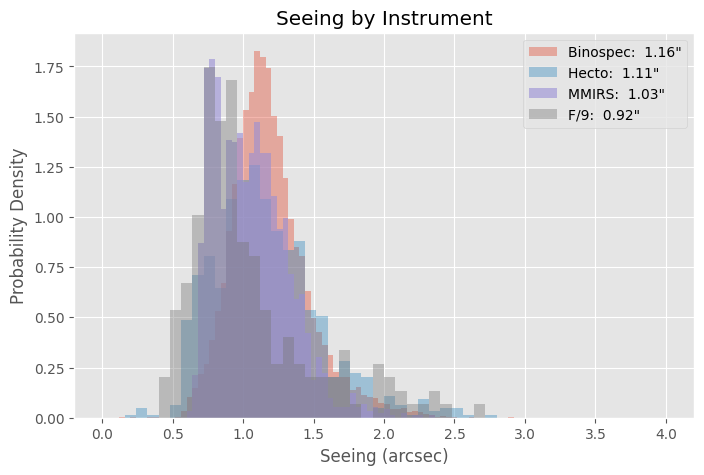

In [19]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    medb = np.median(fixed['seeing'][fixed['wfs'] == 'binospec'])
    medf = np.median(fixed['seeing'][fixed['wfs'] == 'f5'])
    medm = np.median(fixed['seeing'][fixed['wfs'] == 'mmirs'])
    med9 = np.median(fixed['seeing'][fixed['wfs'] == 'newf9'])
    plt.hist(fixed['seeing'][fixed['wfs'] == 'binospec'], density=True, bins=100, range=(0.0, 4.), alpha=0.4, label=f"Binospec: {medb: .2f}\"")
    plt.hist(fixed['seeing'][fixed['wfs'] == 'f5'], density=True, bins=50, range=(0.0, 4.), alpha=0.4, label=f"Hecto: {medf: .2f}\"")
    plt.hist(fixed['seeing'][fixed['wfs'] == 'mmirs'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"MMIRS: {medm: .2f}\"")
    plt.hist(fixed['seeing'][fixed['wfs'] == 'newf9'], density=True, bins=50, range=(0.0, 4.), alpha=0.4, label=f"F/9: {med9: .2f}\"")
    plt.legend()
    plt.title("Seeing by Instrument")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Probability Density")
plt.savefig("per_instrument_2024_q2.png")
plt.show()

In [20]:
from minicyclop.io import read_seeing_data

In [21]:
cyclop = read_seeing_data(Path.home() / "MMT/minicyclop/data/MiniCyclop/Data/Seeing_Data.txt")

In [22]:
cyclop

,UT,flux,seeing,r0,isot,epoch_ms
ut,,,,,,
2022-06-08 03:32:32,6/8/2022 3:32:32 AM,2733.7,0.84,135.8,2022-06-08T03:32:32.968,1654659152968
2022-06-08 03:33:27,6/8/2022 3:33:27 AM,2755.7,0.84,134.4,2022-06-08T03:33:27.409,1654659207408
2022-06-08 03:34:23,6/8/2022 3:34:23 AM,2801.6,2.38,47.7,2022-06-08T03:34:23.655,1654659263655
2022-06-08 03:35:16,6/8/2022 3:35:16 AM,2853.2,1.01,112.3,2022-06-08T03:35:16.325,1654659316324
2022-06-08 03:36:00,6/8/2022 3:36:00 AM,2739.0,1.03,110.7,2022-06-08T03:36:00.691,1654659360691
...,...,...,...,...,...,...
2024-07-18 10:27:26,7/18/2024 10:27:26 AM,1391.6,5.29,21.4,2024-07-18T10:27:26.545,1721298446544
2024-07-18 10:28:23,7/18/2024 10:28:23 AM,1983.8,2.30,49.3,2024-07-18T10:28:23.413,1721298503413
2024-07-18 10:29:27,7/18/2024 10:29:27 AM,1585.2,2.23,50.9,2024-07-18T10:29:27.116,1721298567116


In [23]:
cyclop_q1 = cyclop[(cyclop.index >= '2024-04-01') & (cyclop.index < '2024-07-01')]

0.4885714656354739 0.4363633714371663 0.5482638906576807


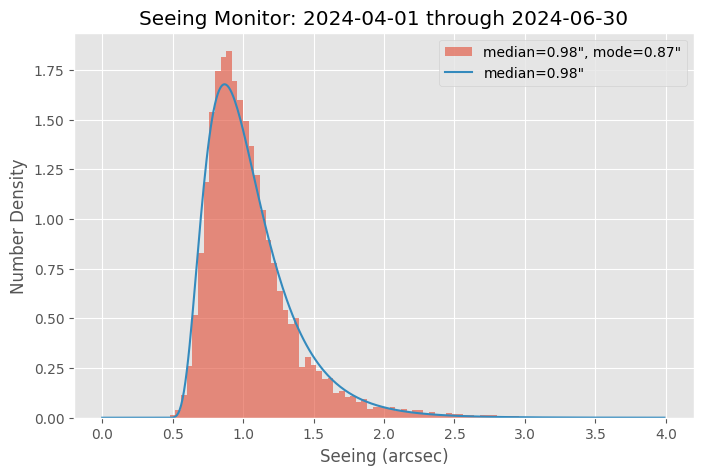

In [24]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(cyclop_q1['seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(cyclop_q1['seeing'])
fit_median = exp_mu + loc

# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(cyclop_q1['seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title("Seeing Monitor: 2024-04-01 through 2024-06-30")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig("2024_q2_cyclop_hist.png")
plt.show()

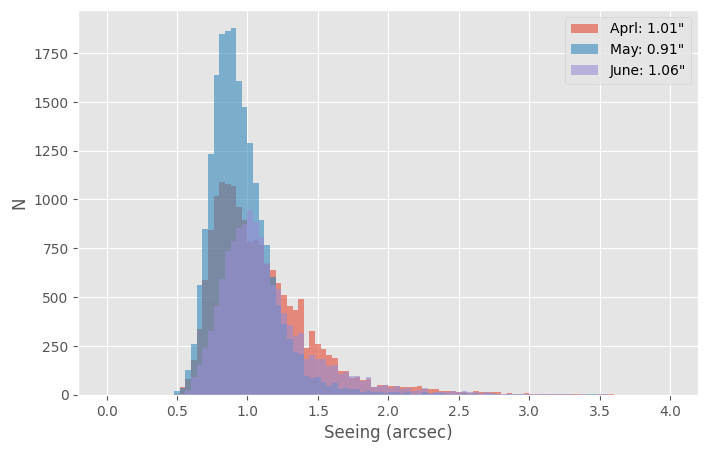

In [25]:
# panda time indexing makes it easy to group by month
fig = plt.figure(figsize=(8, 5))
cyc_months = {}
legends = []
cyc_months['Aprl'] = cyclop_q1.loc['2024-04']
cyc_months['May'] = cyclop_q1.loc['2024-05']
cyc_months['June'] = cyclop_q1.loc['2024-06']

for m in cyc_months.keys():
    plt.hist(cyc_months[m]['seeing'], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(cyc_months[m]['seeing']))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig("2024_q2_cyclop_monthly.png")
plt.show()

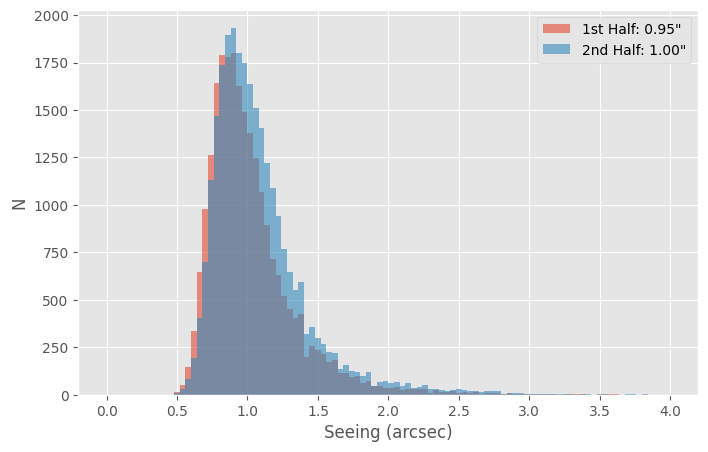

In [26]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = cyclop_q1.between_time(start_time='00:00', end_time='07:00')
second_half = cyclop_q1.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['seeing'])
med_2nd = np.median(second_half['seeing'])

# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("2024_q2_cyclop_1st2nd.png")
plt.show()

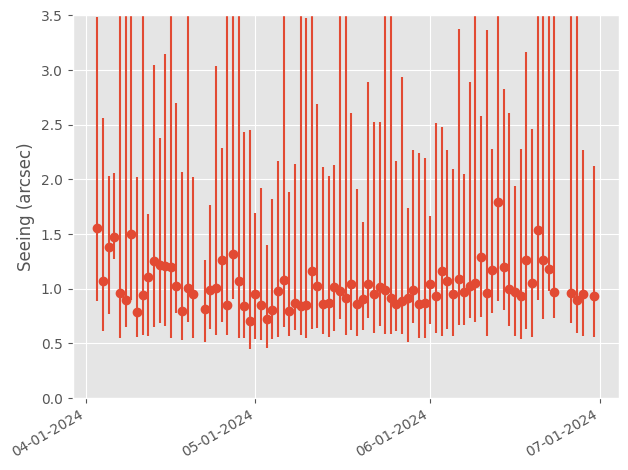

In [27]:
# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
#fixed = fixed["2018-06-30":"2018-10-01"]
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = cyclop_q1.seeing.resample('D').median()
daily['max'] = cyclop_q1.seeing.resample('D').max()
daily['min'] = cyclop_q1.seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
ax.set_ylim(0.0, 3.5)
fig.autofmt_xdate()
plt.tight_layout()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig("2024_q2_cyclop_plot_monthly.png")
plt.show()

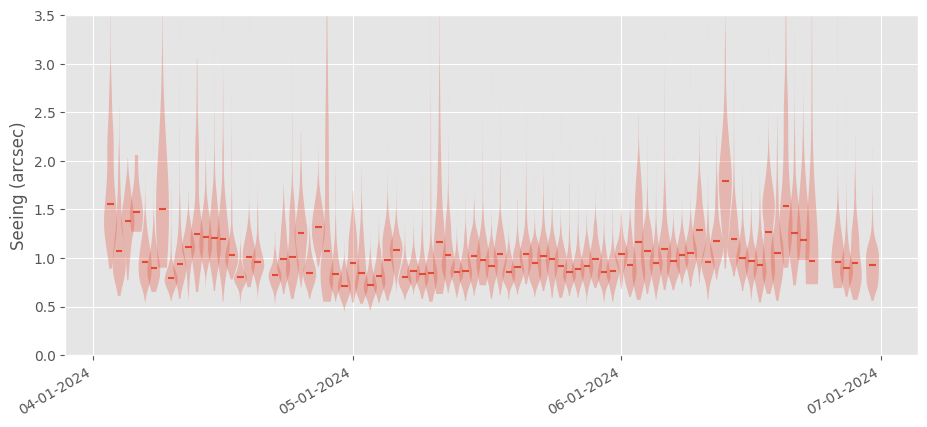

In [28]:
date_list = list(daily.index.strftime('%Y-%m-%d'))
data = [np.array(cyclop_q1.loc[date]['seeing']) for date in date_list]
clean_data = {}
for d, arr in zip(date_list, data):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m-%d").date() for d in clean_data.keys()]

with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    ax.set_ylim(0.0, 3.5)
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig("2024_q2_cyclop_violin.png")
    plt.show()

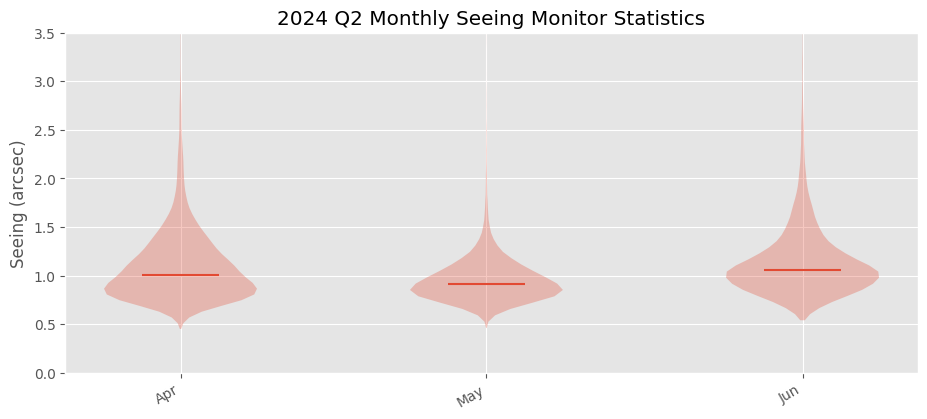

In [29]:
months = sorted(list(set(daily.index.strftime('%Y-%m'))))
mdata = [np.array(cyclop_q1.loc[month]['seeing']) for month in months]
clean_data = {}
for d, arr in zip(months, mdata):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m").date() for d in clean_data.keys()]

with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=100, widths=15,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_ylim(0.0, 3.5)
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig("2024_q2_cyclop_violin_monthly.png")
    plt.title("2024 Q2 Monthly Seeing Monitor Statistics")
    plt.show()

In [30]:
bino = fixed[fixed['wfs'] == 'binospec']
hecto = fixed[fixed['wfs'] == 'f5']
mmirs = fixed[fixed['wfs'] == 'mmirs']
f9 = fixed[fixed['wfs'] == 'newf9']

In [31]:
bino_dates = sorted(list(set(bino.index.strftime('%Y-%m-%d'))))
hecto_dates = sorted(list(set(hecto.index.strftime('%Y-%m-%d'))))
mmirs_dates = sorted(list(set(mmirs.index.strftime('%Y-%m-%d'))))
f9_dates = sorted(list(set(f9.index.strftime('%Y-%m-%d'))))

In [32]:
cyc_bino = np.hstack([np.array(cyclop_q1.loc[date]['seeing']) for date in bino_dates])
cyc_hecto = np.hstack([np.array(cyclop_q1.loc[date]['seeing']) for date in hecto_dates])
cyc_mmirs = np.hstack([np.array(cyclop_q1.loc[date]['seeing']) for date in mmirs_dates])
cyc_f9 = np.hstack([np.array(cyclop_q1.loc[date]['seeing']) for date in f9_dates])

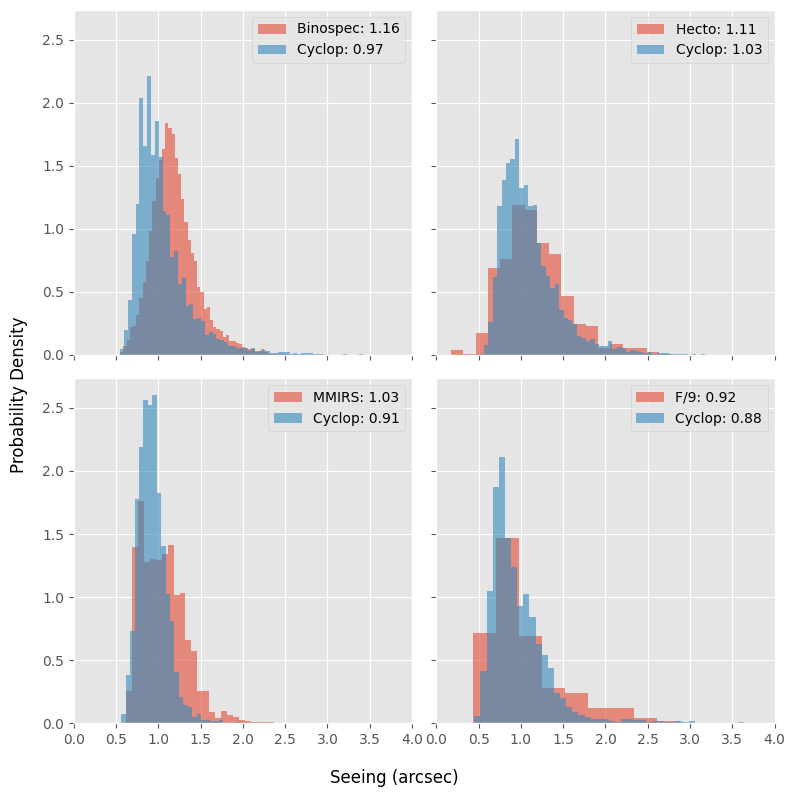

In [33]:
with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
    ax = ax.flat
    fig.subplots_adjust(hspace=0)

    hist(bino['seeing'], bins='scott', ax=ax[0], histtype='stepfilled', alpha=0.6, density=True)
    hist(cyc_bino, bins='scott', ax=ax[0], histtype='stepfilled', alpha=0.6, density=True)
    ax[0].legend([f"Binospec: {np.median(bino['seeing']):.2f}", f"Cyclop: {np.median(cyc_bino):.2f}"])
    ax[0].set_xlim(0, 4)

    hist(hecto['seeing'], bins='scott', ax=ax[1], histtype='stepfilled', alpha=0.6, density=True)
    hist(cyc_hecto, bins='scott', ax=ax[1], histtype='stepfilled', alpha=0.6, density=True)
    ax[1].legend([f"Hecto: {np.median(hecto['seeing']):.2f}", f"Cyclop: {np.median(cyc_hecto):.2f}"])
    ax[1].set_xlim(0, 4)

    hist(mmirs['seeing'], bins='scott', ax=ax[2], histtype='stepfilled', alpha=0.6, density=True)
    hist(cyc_mmirs, bins='scott', ax=ax[2], histtype='stepfilled', alpha=0.6, density=True)
    ax[2].legend([f"MMIRS: {np.median(mmirs['seeing']):.2f}", f"Cyclop: {np.median(cyc_mmirs):.2f}"])
    ax[2].set_xlim(0, 4)

    hist(f9['seeing'], bins='scott', ax=ax[3], histtype='stepfilled', alpha=0.6, density=True)
    hist(cyc_f9, bins='scott', ax=ax[3], histtype='stepfilled', alpha=0.6, density=True)
    ax[3].legend([f"F/9: {np.median(f9['seeing']):.2f}", f"Cyclop: {np.median(cyc_f9):.2f}"])
    ax[3].set_xlim(0, 4)

    fig.supxlabel("Seeing (arcsec)")
    fig.supylabel("Probability Density")

    plt.tight_layout()
    plt.savefig("2024_q2_cyclop_vs_inst.png")
    plt.show()

In [42]:
hdimm = pd.read_csv("hdimm_clean.csv")
hdimm = hdimm.set_index(pd.DatetimeIndex(hdimm['time'], name='ut'))
hdimm

,time,target,seeing,seeing_1,seeing_2,seeing_3,airmass,azimuth,exptime
ut,,,,,,,,,
2024-05-25 06:46:10.756,2024-05-25T06:46:10.756,Vega,0.831,0.808,0.857,0.829,1.369,65.3,0.002
2024-05-25 06:57:29.485,2024-05-25T06:57:29.485,Vega,1.021,1.000,1.027,1.037,1.369,65.3,0.002
2024-05-25 06:58:55.943,2024-05-25T06:58:55.943,Vega,0.966,0.932,1.013,0.954,1.369,65.3,0.002
2024-05-25 07:00:38.899,2024-05-25T07:00:38.899,Vega,1.065,1.057,1.086,1.051,1.369,65.3,0.002
2024-05-25 07:03:03.848,2024-05-25T07:03:03.848,Vega,1.049,1.084,1.020,1.042,1.369,65.3,0.002
2024-05-25 07:04:31.317,2024-05-25T07:04:31.317,Vega,0.879,0.837,0.919,0.881,1.369,65.3,0.002
2024-05-25 07:05:59.419,2024-05-25T07:05:59.419,Vega,0.985,0.943,1.039,0.972,1.369,65.3,0.002
2024-05-25 07:07:26.515,2024-05-25T07:07:26.515,Vega,1.041,1.007,1.084,1.030,1.369,65.3,0.002
2024-05-25 07:18:06.641,2024-05-25T07:18:06.641,Vega,0.999,0.982,1.025,0.992,1.170,66.3,0.002


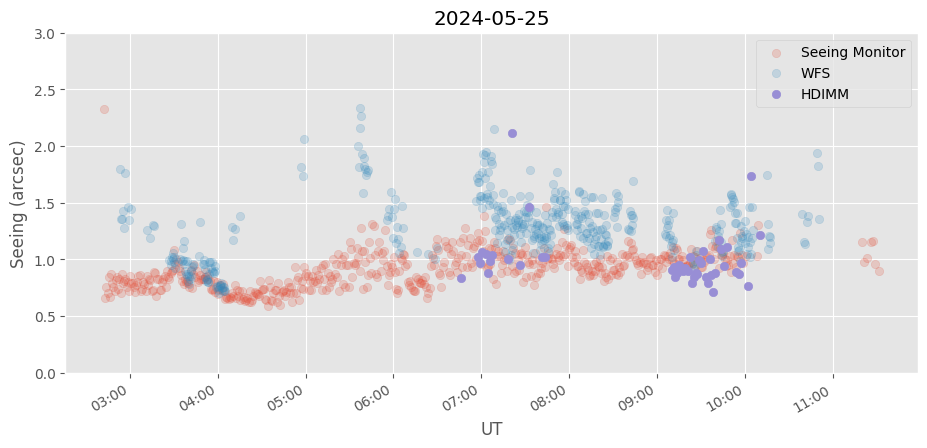

In [48]:
date = '2024-05-25'
seeing_mon = cyclop_q1.loc[date]
seeing_wfs = fixed.loc[date]
fig, ax = plt.subplots(figsize=(11,5))
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
fig.autofmt_xdate()
plt.scatter(seeing_mon.index, seeing_mon['seeing'], alpha=0.2, label="Seeing Monitor")
plt.scatter(seeing_wfs.index, seeing_wfs['seeing'], alpha=0.2, label="WFS")
plt.scatter(hdimm.loc[date].index, hdimm.loc[date]['seeing'], label="HDIMM")
plt.ylabel("Seeing (arcsec)")
plt.title(date)
plt.xlabel("UT")
plt.ylim(0,3)
plt.legend()
plt.savefig("hdimm_cyclop_wfs.png")
plt.show()